In [1]:
%load_ext autotime
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.extend(["../"])

time: 672 µs


In [3]:
from sklearn.model_selection import train_test_split
from core.tools.data_import import *
from core.tools.time_series import *
from constants import *

time: 133 ms


In [4]:
from pprint import pprint
pprint(UNRATE_DIR)
file_dir = input("Select Directory ")

{'EC2': '/home/ec2-user/code/EFANN/data/UNRATE.csv',
 'MAC': '/Users/tianyudu/Documents/Academics/EconForecasting/EFANN/data/UNRATE.csv'}
Select Directory 
time: 526 ms


In [5]:
df = load_dataset(UNRATE_DIR["EC2"])
df_d1 = differencing(df, periods=1, order=1)

lags = list(range(1, 25))
X_FEATURES = len(lags)
X_raw, y_raw = gen_supervised(df_d1, predictors=lags)
X_raw, y_raw = clean_nan(X_raw, y_raw)

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64
25 (2.94%) observations with Nan are dropped.
time: 27.3 ms


In [6]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

time: 4.01 ms


In [7]:
# Expand dimension so it fits the RNN input place holder.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_val = np.expand_dims(X_val, axis=2)

y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)
y_val = np.expand_dims(y_val, axis=1)

time: 964 µs


In [8]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (528, 24, 1)
y_train shape: (528, 1, 1)
X_test shape: (165, 24, 1)
y_test shape: (165, 1, 1)
X_validation shape: (132, 24, 1)
y_validation shape: (132, 1, 1)
time: 568 µs


In [9]:
num_time_steps = len(lags)
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_neurons = 64
# Number of output series
num_outputs = 1
learning_rate = 0.01
num_iter = 100
batch_size = 1

time: 629 µs


In [10]:
# THIS IS REAL
size_train = 24*28 + 1
train = df_d1[:size_train]
test = df_d1[size_train:]
print(train.shape)
print(test.shape)

(673, 1)
(177, 1)
time: 1.29 ms


In [11]:
X_data = train[:size_train-1]
X_batches = X_data.values.reshape(-1, num_time_steps, 1)
print(x_batches.shape)

NameError: name 'x_batches' is not defined

time: 111 ms


In [40]:
y_data = train[num_outputs: size_train]
y_batches = y_data.values.reshape(-1, num_time_steps, num_outputs)
print(y_batches.shape)

(28, 24, 1)
time: 1.22 ms


In [41]:
tf.reset_default_graph()
# setting up
X = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_inputs],
    name="Input_placeholder")
y = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_outputs],
    name="Output_placeholder")

time: 2.94 ms


In [42]:
# Build RNN.
cell = tf.contrib.rnn.LSTMCell(
    num_units=num_neurons,
    activation=tf.nn.relu
)
    
rnn_output, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
stacked_rnn_output = tf.reshape(rnn_output, [-1, num_neurons])

stacked_outputs = tf.layers.dense(stacked_rnn_output, num_outputs)
outputs = tf.reshape(stacked_outputs, [-1, num_time_steps, num_outputs])

time: 102 ms


In [43]:
# Operators
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

time: 233 ms


In [44]:
hist = {"train": [], "val": []}
with tf.Session() as sess:
    sess.run(init)
    for e in range(num_iter):
        sess.run(train,
                 feed_dict={X: X_batches, y: y_batches})
        if e % 10 == 0:
            train_mse = loss.eval(feed_dict={X: X_batches, y: y_batches})
            print(f"Iteratin [{e}]: Training MSE {train_mse}")
#             val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
#             hist["train"].append(train_mse)
#             hist["val"].append(val_mse)
#             print(f"Iteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}")
    
    gen_pred = lambda src: np.squeeze(outputs.eval(feed_dict={X: src}))
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)
    

Iteratin [0]: Training MSE nan
Iteratin [10]: Training MSE nan
Iteratin [20]: Training MSE nan
Iteratin [30]: Training MSE nan
Iteratin [40]: Training MSE nan
Iteratin [50]: Training MSE nan
Iteratin [60]: Training MSE nan
Iteratin [70]: Training MSE nan
Iteratin [80]: Training MSE nan
Iteratin [90]: Training MSE nan
time: 1.12 s


In [30]:
# clean = lambda x: np.squeeze(x[:, -1: ])
# pred_train = clean(pred_train)
# pred_val = clean(pred_val)
# pred_test = clean(pred_test)
p_train

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

time: 4.63 ms


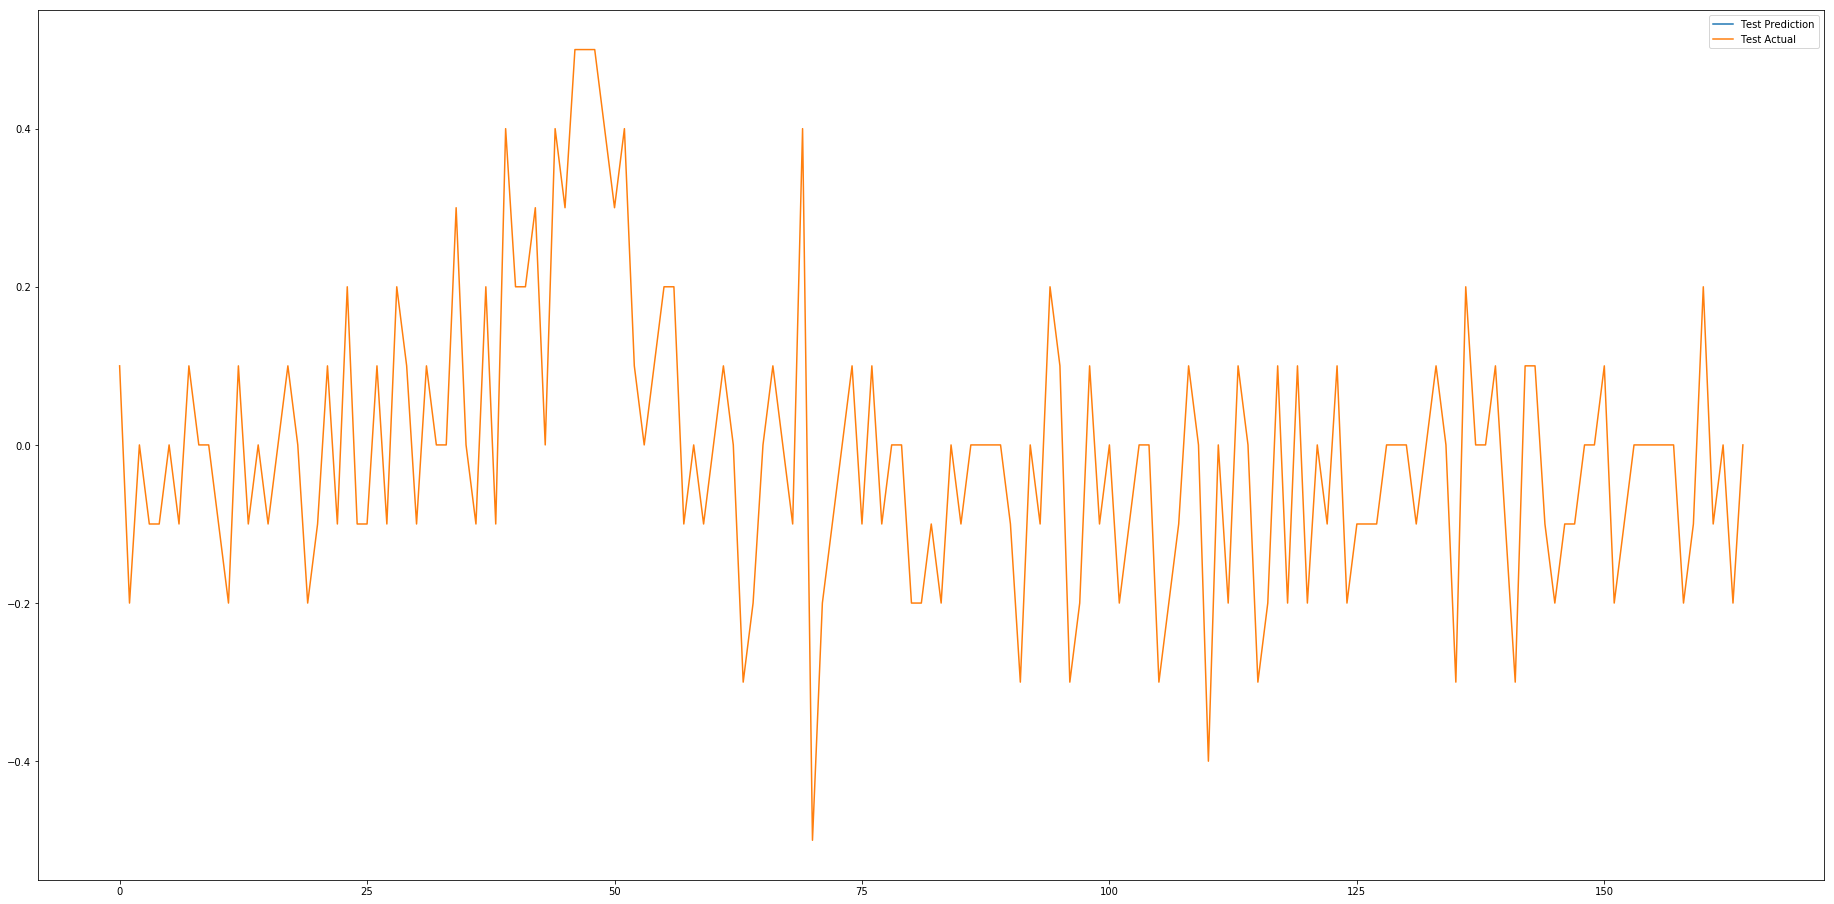

time: 572 ms


In [62]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(pred_test)
plt.plot(np.squeeze(y_test))
plt.legend(["Test Prediction", "Test Actual"])
plt.show()

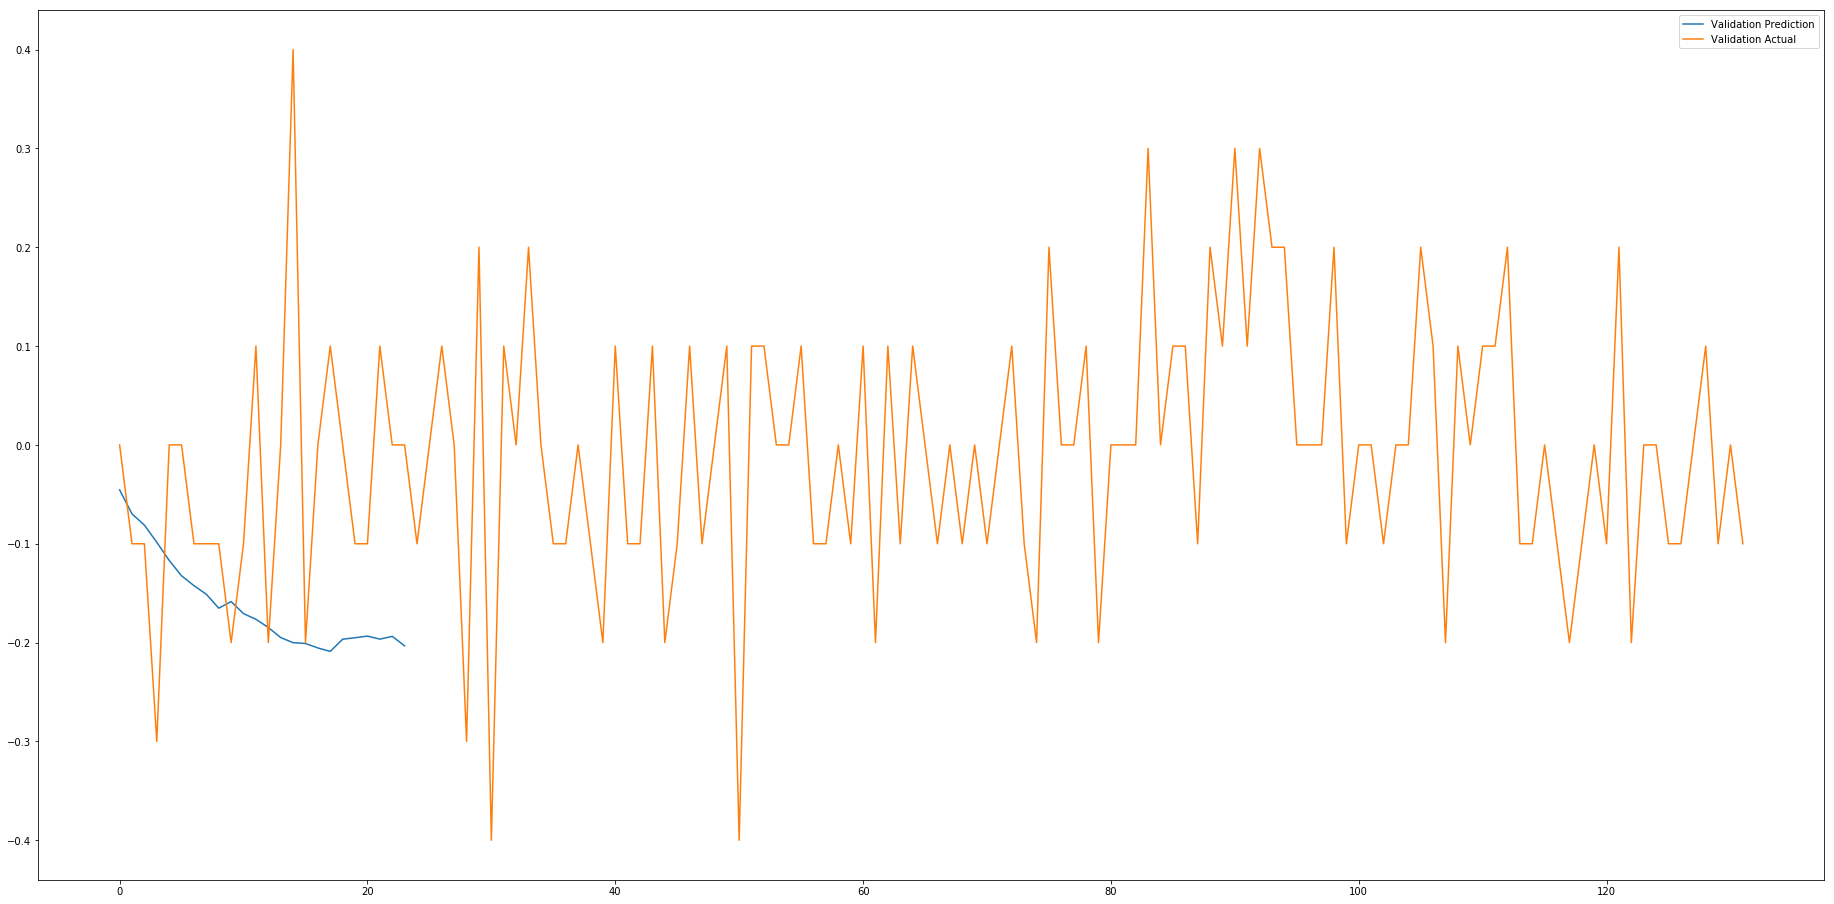

time: 587 ms


In [54]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(pred_val)
plt.plot(np.squeeze(y_val))
plt.legend(["Validation Prediction", "Validation Actual"])
plt.show()

In [ ]:
plt.close()
plt.plot(np.log(hist["train"]))
plt.plot(np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()